In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

from nltk.tokenize.treebank import TreebankWordDetokenizer
%matplotlib inline

# Downloading and Preprocessing the Data

In [2]:
df = pd.read_csv('../data/ner_dataset.csv', encoding = "ISO-8859-1")
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 41951,the,NN,O
freq,1,52573,145807,887908


In [3]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
print(df['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [5]:
df = df.fillna(method = 'ffill')

In [6]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [7]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [8]:
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [9]:
sentences = getter.sentences

In [10]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [11]:
reduced_tag_set = ['B-geo', 'B-gpe', 'B-org', 'B-per', 'B-tim', 'I-geo',
                   'I-gpe', 'I-org', 'I-per', 'I-tim', 'O']

In [90]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
y = [[label if label in reduced_tag_set else 'O' for label in y_i] for y_i in y]  # reduce tag set

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.025)

In [14]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)

# GMB-Simple-Blurry

In [92]:
import copy, random

def blur_labels(y, frac=0.25):
    y_new = []
    error_array = []
    
    counter = 0
    
    for i in range(len(y)):
        error_array.append(list())
        y_new.append(list())
        change_steps = 0
        change_to = None
        
        for j in range(len(y[i])):
            
            current_tag = y[i][j]
            if current_tag=='B-geo' and  j >= 3:
                for k in range(3):
                    y_new[i][j - k - 1] = current_tag
                    error_array[i][j - k - 1] = True
                
                y_new[i].append(current_tag)
                error_array[i].append(False)
            else:
                error_array[i].append(False)
                y_new[i].append(current_tag)
        
    return y_new, error_array

In [93]:
y_train_new, error_train_array = blur_labels(y_train)

In [94]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 818759
Num errs: 72683


0.08877215395494889

In [95]:
print(len(X_train))

37407


In [19]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.8483061494875579


In [20]:
report = flat_classification_report(y_test, y_pred, output_dict=True)
clean_precision, clean_recall, clean_f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
print(flat_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-geo       0.85      0.91      0.88      7526
       B-gpe       0.97      0.94      0.95      3172
       B-org       0.81      0.72      0.76      4024
       B-per       0.85      0.84      0.84      3420
       B-tim       0.93      0.88      0.90      4089
       I-geo       0.81      0.79      0.80      1522
       I-gpe       0.96      0.59      0.73        37
       I-org       0.83      0.78      0.80      3260
       I-per       0.84      0.91      0.87      3484
       I-tim       0.83      0.75      0.79      1283
           O       0.99      0.99      0.99    177544

   micro avg       0.97      0.97      0.97    209361
   macro avg       0.88      0.83      0.85    209361
weighted avg       0.97      0.97      0.97    209361



In [21]:
crf.fit(X_train, y_train_new)
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.776479596400982


In [22]:
report = flat_classification_report(y_test, y_pred, output_dict=True)
dirty_precision, dirty_recall, dirty_f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
print(flat_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-geo       0.27      0.87      0.41      7526
       B-gpe       0.96      0.89      0.93      3172
       B-org       0.76      0.71      0.73      4024
       B-per       0.84      0.81      0.82      3420
       B-tim       0.92      0.82      0.87      4089
       I-geo       0.85      0.62      0.71      1522
       I-gpe       0.92      0.59      0.72        37
       I-org       0.79      0.76      0.78      3260
       I-per       0.84      0.85      0.85      3484
       I-tim       0.83      0.73      0.78      1283
           O       0.99      0.91      0.95    177544

   micro avg       0.89      0.89      0.89    209361
   macro avg       0.82      0.78      0.78    209361
weighted avg       0.95      0.89      0.91    209361



# Understanding the Mistakes

### Seeing the training data

In [23]:
for i in range(10):
    print("-", end="")
    for w, word in enumerate(X_train[i]):
        word = word['word.lower()']
        if error_train_array[i][w]:
            print('*', end='')            
        if y_train_new[i][w] == 'O':
            print(word.lower(), end=' ')
        else:
            print(word.upper(), end=' ')            
    print()

-MR. CHOLMONDELEY was charged with killing a plainclothes KENYAN game warden who was investigating allegations his ranch harbored illegal trade in game meat . 
-and the chairman of the U.S. JOINT CHIEFS OF STAFF GENERAL PETER PACE SUNDAY flatly denied recent media reports of a scheduled withdrawal of AMERICAN AND BRITISH forces . 
-the MONGOLS gained fame in the 13TH CENTURY when under CHINGGIS KHAAN they established a huge EURASIAN empire through conquest . 
-journalists in KENYA and abroad are urging KENYAN PRESIDENT MWAI KIBAKI to reject legislation that could require reporters to divulge their news sources . 
-one *ENDED *AFTER *A U.S. ship fired warning shots to deter the IRANIAN vessel . 
-he had previously been jailed and fined for his work . 
-RSF says the recently-detained journalists include photographers MAJID SAIDI and TOHID BIGHI , blogger HENGHAMEH SHAHIDI , and journalists SOMAIEH NOSRATI and SAID MATINPOUR . 
-the leaders are expected to use the summit , which opens MON

### Seeing the predictions on the test data

In [24]:
for i in range(10):
    print("-", end="")
    for w, word in enumerate(X_test[i]):
        word = word['word.lower()']
        if y_pred[i][w] != y_test[i][w]:
            print('*', end='')
            
        if y_pred[i][w] == 'O':
            print(word.lower(), end=' ')
        else:
            print(word.upper(), end=' ')            
    print()

-in last week 's elections , the opposition nationalists won 81 of the *113 *SEATS *IN TAIWAN 's legislature . 
-the court said in its decision WEDNESDAY that the principle of universal jurisdiction takes precedence over the existence , or not , of national interests . 
-NORTH KOREA has rejected a recent UNITED NATIONS resolution *THAT *CRITICIZED PYONGYANG 's human rights record . 
-fighting THURSDAY left 12 suspected TALEBAN militants *DEAD *IN *SOUTHERN NAWZAD district . 
-meanwhile , the *CHIEF U.S. negotiator at stalled nuclear talks , *CHRISTOPHER *HILL *, *SAYS NORTH KOREA is blocking progress in the negotiations . 
-all the goods were once driven out by the ills from that common share which they each had in the affairs of mankind ; for the ills by reason of their numbers had prevailed to possess the earth . 
-DEMOCRATIC PARTY officials say U.S. SENATOR CHRISTOPHER DODD of the *NORTHEASTERN *STATE *OF CONNECTICUT will seek the *2008 democratic presidential nomination . 
-in late

# Let's Try to Fix the Mistakes

For reference, the clean F1 is: **0.84** 

In [25]:
def measure_method(error_pred, error_array, X, y_corrected):
    # measure what percent of errors are fixed
    np = 0; nn=0; tp = 0; fp = 0;
    for i in range(len(error_pred)):
        for j in range(len(error_pred[i])):
            if error_pred[i][j] and error_pred[i][j] == error_array[i][j]:
                tp += 1
            elif error_pred[i][j]:
                fp += 1
            if error_array[i][j]:
                np += 1
            else:
                nn += 1

    
    print("TP errors detected: {}".format(tp/np))
    print("FP errors detected: {}".format(fp/nn)) 

    # measure accuracy
    crf.fit(X, y_corrected)
    y_pred = crf.predict(X_test)
    f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
    print("F1 score on trained model: {}".format(f1_score))
    
    report = flat_classification_report(y_test, y_pred, output_dict=True)
    precision, recall, f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
    print(flat_classification_report(y_test, y_pred))

    return precision, recall, f1

## Pseudolabeled from Validation

In [26]:
def pseudolabeled_on_validation(X_val, y_val):
    
    crf.fit(X_val, y_val)
    y_pred = crf.predict(X_train)

    error_pred = []
    y_corrected = []

    for i in range(len(y_pred)):    
        error_pred.append([])
        y_corrected.append([])

        for j in range(len(y_pred[i])):
            if not(y_pred[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_pred)

### GTC with X, y, neighboring y

In [96]:
keys_prioritized = ['word.isupper()', 'word.istitle()', 'word.isdigit()', '+1:word.istitle()', 
                    '+1:word.isupper()', 'BOS', 'bias',  'word.lower()', 'word[-3:]', 'word[-2:]',
                    '+1:word.lower()', 'postag', 'postag[:2]', '+1:postag', '+1:postag[:2]', 
                    '-1:postag', '-1:postag[:2]', '-1:word.istitle()', '-1:word.lower()',
                    '-1:word.isupper()', 'EOS']

for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        print(X_train[i][j].keys())
        1/0
        for key in X_train[i][j].keys():
            if not(key in keys_prioritized):
                print(key)

dict_keys(['bias', 'word.lower()', 'word[-3:]', 'word[-2:]', 'word.isupper()', 'word.istitle()', 'word.isdigit()', 'postag', 'postag[:2]', 'BOS', '+1:word.lower()', '+1:word.istitle()', '+1:word.isupper()', '+1:postag', '+1:postag[:2]'])


ZeroDivisionError: division by zero

In [97]:
def gtc_with_x_y_neighboring_y(X_val, y_val, num_x_keys=1):
    keys_prioritized = ['word.isupper()', 'word.istitle()', 'word.isdigit()', '+1:word.istitle()', 
                        '+1:word.isupper()', 'BOS', 'bias',  'word.lower()', 'word[-3:]', 'word[-2:]',
                        '+1:word.lower()', 'postag', 'postag[:2]', '+1:postag', '+1:postag[:2]', 
                        '-1:postag', '-1:postag[:2]', '-1:word.istitle()', '-1:word.lower()',
                        '-1:word.isupper()', 'EOS']
    
    crf.fit(X_train, y_train_new)
    y_val_pred = crf.predict(X_val)

    correction_network_input = []

    for i in range(len(y_val_pred)):
        correction_network_input.append([])
        for j in range(len(y_val_pred[i])):
            if num_x_keys is None:
                X_val_sub = X_val[i][j].copy()
            else:
                X_val_sub = {k: X_val[i][j][k] for k in keys_prioritized[:num_x_keys] if k in X_val[i][j]}
            correction_network_input[i].append(X_val_sub)
            correction_network_input[i][j]['y'] = y_val_pred[i][j]     
            if j >= 1:
                correction_network_input[i][j]['y-1'] = y_val_pred[i][j-1]
            else:
                correction_network_input[i][j]['y-1'] = 'N'
            if j >= 2:
                correction_network_input[i][j]['y-2'] = y_val_pred[i][j-2]
            else:
                correction_network_input[i][j]['y-2'] = 'N'
            if j < len(y_val_pred[i]) - 1:
                correction_network_input[i][j]['y+1'] = y_val_pred[i][j+1]
            else:
                correction_network_input[i][j]['y+1'] = 'N'
            if j < len(y_val_pred[i]) - 2:
                correction_network_input[i][j]['y+2'] = y_val_pred[i][j+2]
            else:
                correction_network_input[i][j]['y+2'] = 'N'

    crf.fit(correction_network_input, y_val)

    X_expanded = []

    for i in range(len(y_train_new)):
        X_expanded.append([])
        for j in range(len(y_train_new[i])):
            if num_x_keys is None:
                X_train_sub = X_train[i][j].copy()
            else:
                X_train_sub = {k: X_train[i][j][k] for k in keys_prioritized[:num_x_keys] if k in X_train[i][j]}
            X_expanded[i].append(X_train_sub)
            X_expanded[i][j]['y'] = y_train_new[i][j]     
            if j >= 1:
                X_expanded[i][j]['y-1'] = y_train_new[i][j-1]
            else:
                X_expanded[i][j]['y-1'] = 'N'
            if j >= 2:
                X_expanded[i][j]['y-2'] = y_train_new[i][j-2]
            else:
                X_expanded[i][j]['y-2'] = 'N'
            if j < len(y_train_new[i]) - 1:
                X_expanded[i][j]['y+1'] = y_train_new[i][j+1]
            else:
                X_expanded[i][j]['y+1'] = 'N'
            if j < len(y_train_new[i]) - 2:
                X_expanded[i][j]['y+2'] = y_train_new[i][j+2]
            else:
                X_expanded[i][j]['y+2'] = 'N'

    # Go from X_expanded to X_corrected
    y_corrected = crf.predict(X_expanded)

    error_pred = []

    for i in range(len(y_corrected)):    
        error_pred.append([])    
        for j in range(len(y_corrected[i])):
            if not(y_corrected[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_corrected)

### GTC with y, neighboring y only

In [48]:
def gtc_with_y_neighboring_y(X_val, y_val, num_ys=1):
    
    crf.fit(X_train, y_train_new)
    y_val_pred = crf.predict(X_val)

    correction_network_input = []

    for i in range(len(y_val_pred)):
        correction_network_input.append([])
        for j in range(len(y_val_pred[i])):
            correction_network_input[i].append(dict())
            correction_network_input[i][j]['y'] = y_val_pred[i][j] 
            for k in range(1, 1+num_ys):
                if j >= k:
                    correction_network_input[i][j]['y-{}'.format(k)] = y_val_pred[i][j-k]
                else:
                    correction_network_input[i][j]['y-{}'.format(k)] = 'N'
                if j < len(y_val_pred[i]) - k:
                    correction_network_input[i][j]['y+{}'.format(k)] = y_val_pred[i][j+1]
                else:
                    correction_network_input[i][j]['y+{}'.format(k)] = 'N'
    
    crf.fit(correction_network_input, y_val)

    X_expanded = []

    for i in range(len(y_train_new)):
        X_expanded.append([])
        for j in range(len(y_train_new[i])):
            X_expanded[i].append(dict())
            X_expanded[i][j]['y'] = y_train_new[i][j]     
            for k in range(1, 1+num_ys):
                if j >= k:
                    X_expanded[i][j]['y-{}'.format(k)] = y_train_new[i][j-k]
                else:
                    X_expanded[i][j]['y-{}'.format(k)] = 'N'
                if j < len(y_train_new[i]) - k:
                    X_expanded[i][j]['y+{}'.format(k)] = y_train_new[i][j+k]
                else:
                    X_expanded[i][j]['y+{}'.format(k)] = 'N'

    # Go from X_expanded to X_corrected
    y_corrected = crf.predict(X_expanded)

    error_pred = []

    for i in range(len(y_corrected)):    
        error_pred.append([])    
        for j in range(len(y_corrected[i])):
            if not(y_corrected[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_corrected)

### How do results change based on markov blanket size?

In [32]:
n = 100
X_val_ = X_val[:n]
y_val_ = y_val[:n]

In [34]:
ppr, pre, pf1 = pseudolabeled_on_validation(X_val_, y_val_)

TP errors detected: 0.9515329539195888
FP errors detected: 0.06473636304800147


C:\Users\islam\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score on trained model: 0.6097666647500205


C:\Users\islam\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-geo       0.69      0.83      0.75      7526
       B-gpe       0.87      0.74      0.80      3172
       B-org       0.56      0.48      0.51      4024
       B-per       0.75      0.58      0.65      3420
       B-tim       0.88      0.67      0.76      4089
       I-geo       0.43      0.65      0.52      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.50      0.49      0.49      3260
       I-per       0.76      0.68      0.72      3484
       I-tim       0.83      0.37      0.52      1283
           O       0.98      0.99      0.98    177544

   micro avg       0.94      0.94      0.94    209361
   macro avg       0.66      0.59      0.61    209361
weighted avg       0.94      0.94      0.94    209361



In [35]:
yny_prs = []
yny_res = []
yny_f1s = []

iss = range(10)

for i in iss:
    pr, re, f1 = gtc_with_y_neighboring_y(X_val_, y_val_, num_ys=i)
    yny_prs.append(pr)
    yny_res.append(re)
    yny_f1s.append(f1)

TP errors detected: 1.0
FP errors detected: 0.030239311931721947
F1 score on trained model: 0.7063974578376757
              precision    recall  f1-score   support

       B-geo       0.84      0.14      0.23      7526
       B-gpe       0.98      0.91      0.95      3172
       B-org       0.82      0.66      0.74      4024
       B-per       0.85      0.80      0.82      3420
       B-tim       0.93      0.85      0.89      4089
       I-geo       0.83      0.72      0.77      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.82      0.74      0.78      3260
       I-per       0.84      0.87      0.85      3484
       I-tim       0.83      0.72      0.77      1283
           O       0.95      1.00      0.97    177544

   micro avg       0.94      0.94      0.94    209361
   macro avg       0.79      0.67      0.71    209361
weighted avg       0.94      0.94      0.93    209361

TP errors detected: 1.0
FP errors detected: 0.006014813958003709
F1 score on


TP errors detected: 0.8500515456638092
FP errors detected: 0.01495854487770016
F1 score on trained model: 0.7399603590309792
              precision    recall  f1-score   support

       B-geo       0.80      0.83      0.81      7526
       B-gpe       0.98      0.89      0.93      3172
       B-org       0.78      0.63      0.70      4024
       B-per       0.85      0.72      0.78      3420
       B-tim       0.92      0.85      0.88      4089
       I-geo       0.73      0.68      0.70      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.75      0.74      0.75      3260
       I-per       0.83      0.89      0.85      3484
       I-tim       0.80      0.70      0.75      1283
           O       0.98      0.99      0.99    177544

   micro avg       0.96      0.96      0.96    209361
   macro avg       0.77      0.72      0.74    209361
weighted avg       0.96      0.96      0.96    209361



In [38]:
yny_prs = []
yny_res = []
yny_f1s = []

iss = range(10)

for i in iss:
    pr, re, f1 = gtc_with_y_neighboring_y(X_val_, y_val_, num_ys=i)
    yny_prs.append(pr)
    yny_res.append(re)
    yny_f1s.append(f1)

TP errors detected: 0.850644673850108
FP errors detected: 0.016257072707919366
F1 score on trained model: 0.737953356733842
              precision    recall  f1-score   support

       B-geo       0.79      0.83      0.81      7526
       B-gpe       0.98      0.89      0.93      3172
       B-org       0.78      0.63      0.70      4024
       B-per       0.86      0.70      0.77      3420
       B-tim       0.92      0.85      0.88      4089
       I-geo       0.71      0.70      0.70      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.74      0.75      0.75      3260
       I-per       0.83      0.87      0.85      3484
       I-tim       0.77      0.70      0.73      1283
           O       0.98      0.99      0.99    177544

   micro avg       0.96      0.96      0.96    209361
   macro avg       0.76      0.72      0.74    209361
weighted avg       0.96      0.96      0.96    209361

TP errors detected: 0.8287554193557498
FP errors detected: 0.01

Text(0, 0.5, 'Model performance (F1 score)')

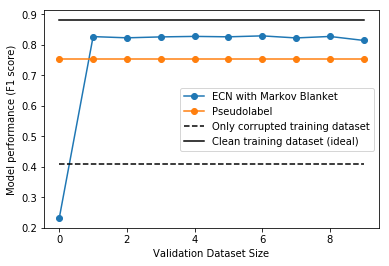

In [37]:
plt.plot(iss, yny_f1s, '-o', label='ECN with Markov Blanket')
plt.plot(iss, [pf1]*len(iss), '-o', label='Pseudolabel')
plt.plot(iss, [dirty_f1]*len(iss), 'k--', label='Only corrupted training dataset')
plt.plot(iss, [clean_f1]*len(iss), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Validation Dataset Size')
plt.ylabel('Model performance (F1 score)')

In [ ]:
iss2 = [10, 15, 20]

for i in iss2:
    pr, re, f1 = gtc_with_y_neighboring_y(X_val_, y_val_, num_ys=i)
    yny_prs.append(pr)
    yny_res.append(re)
    yny_f1s.append(f1)

Text(0, 0.5, 'Model performance (F1 score)')

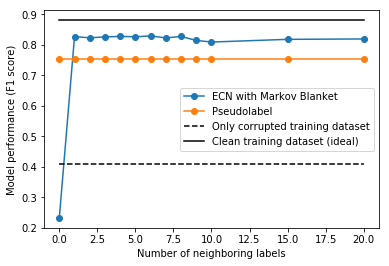

In [44]:
plt.plot(list(iss) + iss2, yny_f1s, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + iss2, [pf1]*len(list(iss)+iss2), '-o', label='Pseudolabel')
plt.plot(list(iss) + iss2, [dirty_f1]*len(list(iss)+iss2), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + iss2, [clean_f1]*len(list(iss)+iss2), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of neighboring labels')
plt.ylabel('Model performance (F1 score)')

Text(0.5, 1.0, 'Precision')

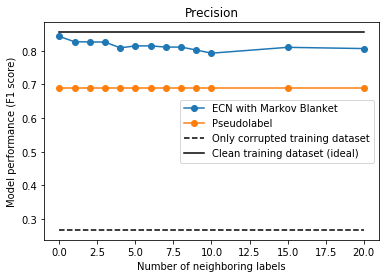

In [45]:
plt.plot(list(iss) + iss2, yny_prs, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + iss2, [ppr]*len(list(iss)+iss2), '-o', label='Pseudolabel')
plt.plot(list(iss) + iss2, [dirty_precision]*len(list(iss)+iss2), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + iss2, [clean_precision]*len(list(iss)+iss2), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of neighboring labels')
plt.ylabel('Model performance (F1 score)')
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

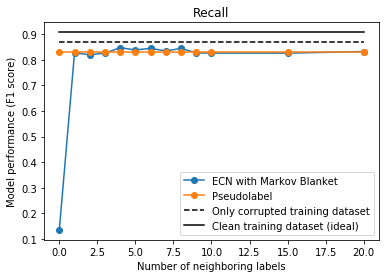

In [46]:
plt.plot(list(iss) + iss2, yny_res, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + iss2, [pre]*len(list(iss)+iss2), '-o', label='Pseudolabel')
plt.plot(list(iss) + iss2, [dirty_recall]*len(list(iss)+iss2), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + iss2, [clean_recall]*len(list(iss)+iss2), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of neighboring labels')
plt.ylabel('Model performance (F1 score)')
plt.title('Recall')

#### With X features

In [54]:
xny_prs = []
xny_res = []
xny_f1s = []

iss = range(10)

for i in iss:
    pr, re, f1 = gtc_with_x_y_neighboring_y(X_val_, y_val_, num_x_keys=i)
    xny_prs.append(pr)
    xny_res.append(re)
    xny_f1s.append(f1)

TP errors detected: 1.0
FP errors detected: 0.008482429940774463
F1 score on trained model: 0.7435239235063609
              precision    recall  f1-score   support

       B-geo       0.83      0.82      0.82      7526
       B-gpe       0.98      0.90      0.94      3172
       B-org       0.80      0.64      0.71      4024
       B-per       0.82      0.74      0.78      3420
       B-tim       0.92      0.83      0.88      4089
       I-geo       0.77      0.65      0.71      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.74      0.74      0.74      3260
       I-per       0.84      0.86      0.85      3484
       I-tim       0.81      0.73      0.77      1283
           O       0.98      0.99      0.99    177544

   micro avg       0.96      0.96      0.96    209361
   macro avg       0.77      0.72      0.74    209361
weighted avg       0.96      0.96      0.96    209361

TP errors detected: 1.0
FP errors detected: 0.008595345404271785
F1 score on


TP errors detected: 0.9313524734857579
FP errors detected: 0.006432050365804791
F1 score on trained model: 0.7572953123147127
              precision    recall  f1-score   support

       B-geo       0.80      0.90      0.85      7526
       B-gpe       0.97      0.92      0.95      3172
       B-org       0.79      0.67      0.72      4024
       B-per       0.86      0.74      0.79      3420
       B-tim       0.93      0.85      0.88      4089
       I-geo       0.73      0.76      0.74      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.80      0.77      0.79      3260
       I-per       0.84      0.87      0.86      3484
       I-tim       0.84      0.69      0.76      1283
           O       0.99      0.99      0.99    177544

   micro avg       0.97      0.97      0.97    209361
   macro avg       0.78      0.74      0.76    209361
weighted avg       0.97      0.97      0.97    209361



Text(0, 0.5, 'Model performance (F1 score)')

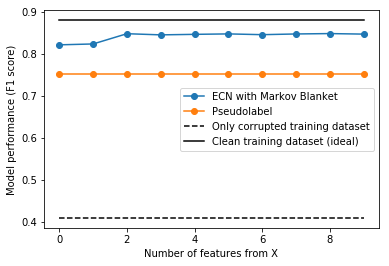

In [55]:
plt.plot(iss, xny_f1s, '-o', label='ECN with Markov Blanket')
plt.plot(iss, [pf1]*len(iss), '-o', label='Pseudolabel')
plt.plot(iss, [dirty_f1]*len(iss), 'k--', label='Only corrupted training dataset')
plt.plot(iss, [clean_f1]*len(iss), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of features from X')
plt.ylabel('Model performance (F1 score)')

In [72]:
len(keys_prioritized)

20

In [71]:
keys_prioritized = ['word.isupper()', 'word.istitle()', 'word.isdigit()', '+1:word.istitle()', 
                        '+1:word.isupper()', 'BOS', 'bias',  'word.lower()', 'word[-3:]', 'word[-2:]',
                        '+1:word.lower()', 'postag', 'postag[:2]', '+1:postag', '+1:postag[:2]', 
                        '-1:postag', '-1:postag[:2]', '-1:word.istitle()', '-1:word.lower()',
                        '-1:word.isupper()',]

keys_prioritized[:max(list(iss2))]

['word.isupper()',
 'word.istitle()',
 'word.isdigit()',
 '+1:word.istitle()',
 '+1:word.isupper()',
 'BOS',
 'bias',
 'word.lower()',
 'word[-3:]',
 'word[-2:]',
 '+1:word.lower()',
 'postag',
 'postag[:2]',
 '+1:postag',
 '+1:postag[:2]',
 '-1:postag',
 '-1:postag[:2]',
 '-1:word.istitle()']

In [63]:
iss2 = range(10, 19)

for i in iss2:
    pr, re, f1 = gtc_with_x_y_neighboring_y(X_val_, y_val_, num_x_keys=i)
    xny_prs.append(pr)
    xny_res.append(re)
    xny_f1s.append(f1)

TP errors detected: 0.9364787956673398
FP errors detected: 0.006611062685983473
F1 score on trained model: 0.757312813037327
              precision    recall  f1-score   support

       B-geo       0.81      0.89      0.85      7526
       B-gpe       0.97      0.92      0.95      3172
       B-org       0.79      0.67      0.73      4024
       B-per       0.85      0.75      0.79      3420
       B-tim       0.93      0.85      0.89      4089
       I-geo       0.73      0.75      0.74      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.82      0.75      0.78      3260
       I-per       0.84      0.88      0.86      3484
       I-tim       0.85      0.68      0.76      1283
           O       0.99      0.99      0.99    177544

   micro avg       0.97      0.97      0.97    209361
   macro avg       0.78      0.74      0.76    209361
weighted avg       0.97      0.97      0.97    209361

TP errors detected: 0.9384558896216689
FP errors detected: 0.0

Text(0, 0.5, 'Model performance (F1 score)')

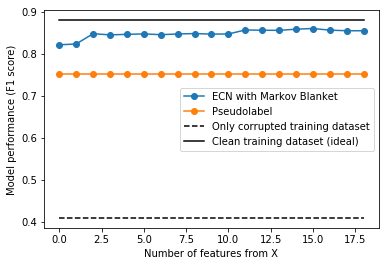

In [65]:
plt.plot(list(iss) + list(iss2), xny_f1s, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + list(iss2), [pf1]*len(list(iss) + list(iss2)), '-o', label='Pseudolabel')
plt.plot(list(iss) + list(iss2), [dirty_f1]*len(list(iss) + list(iss2)), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + list(iss2), [clean_f1]*len(list(iss) + list(iss2)), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of features from X')
plt.ylabel('Model performance (F1 score)')

In [79]:
gtc_with_x_y_neighboring_y(X_val_, y_val_, num_x_keys=25)

TP errors detected: 0.938328790724605
FP errors detected: 0.008123028282569571
F1 score on trained model: 0.7556352798322774
              precision    recall  f1-score   support

       B-geo       0.82      0.90      0.86      7526
       B-gpe       0.97      0.91      0.94      3172
       B-org       0.80      0.67      0.73      4024
       B-per       0.86      0.77      0.81      3420
       B-tim       0.93      0.84      0.88      4089
       I-geo       0.74      0.74      0.74      1522
       I-gpe       0.00      0.00      0.00        37
       I-org       0.81      0.75      0.78      3260
       I-per       0.84      0.88      0.86      3484
       I-tim       0.85      0.62      0.72      1283
           O       0.99      0.99      0.99    177544

   micro avg       0.97      0.97      0.97    209361
   macro avg       0.78      0.73      0.76    209361
weighted avg       0.97      0.97      0.97    209361



(0.8197077647627098, 0.9019399415360085, 0.8588599987347378)

In [98]:
gtc_with_x_y_neighboring_y(X_val_, y_val_, num_x_keys=None)

TP errors detected: 0.9420222060179134
FP errors detected: 0.00498072582417877
F1 score on trained model: 0.766410934484587
              precision    recall  f1-score   support

       B-geo       0.84      0.90      0.87      7502
       B-gpe       0.97      0.91      0.94      3275
       B-org       0.80      0.72      0.75      4032
       B-per       0.85      0.79      0.82      3384
       B-tim       0.93      0.85      0.89      4033
       I-geo       0.80      0.77      0.78      1485
       I-gpe       0.00      0.00      0.00        41
       I-org       0.80      0.78      0.79      3331
       I-per       0.85      0.86      0.86      3433
       I-tim       0.86      0.65      0.74      1266
           O       0.99      0.99      0.99    177263

   micro avg       0.97      0.97      0.97    209045
   macro avg       0.79      0.75      0.77    209045
weighted avg       0.97      0.97      0.97    209045



(0.8438517405459555, 0.8982937883231138, 0.8702221074380165)

Text(0, 0.5, 'Model performance (F1 score)')

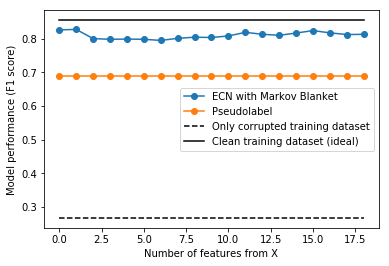

In [100]:
plt.plot(list(iss) + list(iss2), xny_prs, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + list(iss2), [ppr]*len(list(iss) + list(iss2)), '-o', label='Pseudolabel')
plt.plot(list(iss) + list(iss2), [dirty_precision]*len(list(iss) + list(iss2)), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + list(iss2), [clean_precision]*len(list(iss) + list(iss2)), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of features from X')
plt.ylabel('Model performance (F1 score)')

Text(0, 0.5, 'Model performance (F1 score)')

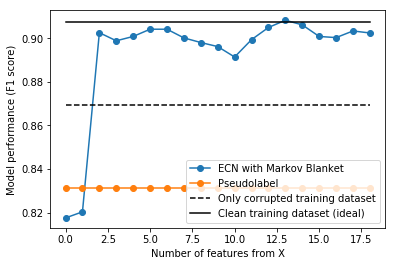

In [101]:
plt.plot(list(iss) + list(iss2), xny_res, '-o', label='ECN with Markov Blanket')
plt.plot(list(iss) + list(iss2), [pre]*len(list(iss) + list(iss2)), '-o', label='Pseudolabel')
plt.plot(list(iss) + list(iss2), [dirty_recall]*len(list(iss) + list(iss2)), 'k--', label='Only corrupted training dataset')
plt.plot(list(iss) + list(iss2), [clean_recall]*len(list(iss) + list(iss2)), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Number of features from X')
plt.ylabel('Model performance (F1 score)')